**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
- [Sélection de 3 classes](#toc2_)    
- [Échantillonnage des images](#toc3_)    
  - [Encodage des catégories](#toc3_1_)    
- [Modèle CNN](#toc4_)    
  - [Pré-traitement](#toc4_1_)    
  - [Configuration : hyperparamètres et métriques](#toc4_2_)    
  - [Paramètres](#toc4_3_)    
  - [Architecture](#toc4_4_)    
  - [Données train / val](#toc4_5_)    
  - [Compilation](#toc4_6_)    
  - [Entraînement](#toc4_7_)    
  - [Évaluation](#toc4_8_)    
  - [Résultats](#toc4_9_)    
- [Approches d'amélioration](#toc5_)    
  - [Pipeline de test](#toc5_1_)    
  - [Améliorations : complexité](#toc5_2_)    
  - [Améliorations : batch size](#toc5_3_)    
  - [Améliorations : dropout](#toc5_4_)    
  - [Améliorations : optimizer](#toc5_5_)    
- [Augmentation des données](#toc6_)    
  - [Augmentation des époques](#toc6_1_)    
  - [Modèle simple](#toc6_2_)    
  - [Modèle plus complexe, exemple à 5 couches](#toc6_3_)    
- [Pré-traitement des données : améliorer l'inférence mais pas le modèle](#toc7_)    
- [Modèles plus performants](#toc8_)    
  - [2 CONV + 2 FC](#toc8_1_)    
  - [3 CONV + 2 FC](#toc8_2_)    
  - [4 CONV + 2 FC](#toc8_3_)    
  - [6 CONV + 2 FC](#toc8_4_)    
  - [Conclusion](#toc8_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
from dotenv import load_dotenv
import os
import yaml
import shutil
import datetime
import time
import logging

# DS, ML & DL
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import Model
from keras.applications.vgg16 import VGG16
from keras.utils import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.layers import GaussianNoise, RandomContrast, RandomBrightness
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda
import tensorflow as tf
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# images & data viz
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps, ImageEnhance, ImageFilter
from scipy.ndimage import median_filter

# home made functions from src folder
from src.get_data import get_tar_and_extract
from src.get_data import create_img_db
from src.display_img import compare_img
from src.models import eval_pretrained_model, ConditionalAugmentation

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

2024-07-29 22:04:48.419253: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 22:04:48.497313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 22:04:49.857727: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Configuration

In [2]:
# environment config
load_dotenv()
IMG_URL = os.getenv("IMG_URL")
ANNOT_URL = os.getenv("ANNOT_URL")

# local config
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

CLASSES_3 = cfg["models"]["classes_3"]
CLASSES_10 = cfg["models"]["classes_10"]
DATA_DIR = cfg["data"]["local_path"]
TRAIN_DIR = os.path.join(DATA_DIR, cfg["data"]["train_dir"])
TEST_DIR = os.path.join(DATA_DIR, cfg["data"]["test_dir"])
IMG_DIR = os.path.join(DATA_DIR, cfg["data"]["img_dir"])
ANNOT_DIR = os.path.join(DATA_DIR, cfg["data"]["annot_dir"])
LOG_DIR = cfg["log"]["log_dir"]
CHKPT_DIR = os.path.join(DATA_DIR, cfg["data"]["checkpoint_dir"])
IMG_DB_URI = os.path.join(DATA_DIR, cfg["data"]["img_db_uri"])

Images et annotations, création de la BDD

In [3]:
if os.path.exists(IMG_DB_URI):
    img_df = pd.read_csv(IMG_DB_URI, index_col=0)
else:
    # download, extract and store data
    print("⚙️ Downloading images...")
    get_tar_and_extract(IMG_URL, DATA_DIR)
    print("⚙️ Downloading annotations...")
    get_tar_and_extract(ANNOT_URL, DATA_DIR)
    print("⚙️ Creating database...")

    # create database
    img_df = create_img_db(IMG_DIR, ANNOT_DIR, IMG_DB_URI)

# Sélection de 3 classes, échantillonnage, encodage, jeux de données

Conservation des classes vues dans le notebook précédent :
- Carlin (*pug*),
- Husky de Sibérie (*Siberian_husky*),
- Barzoï (*borzoi*)

171.5 images per class, 443.0 avg width, 386.0 avg height


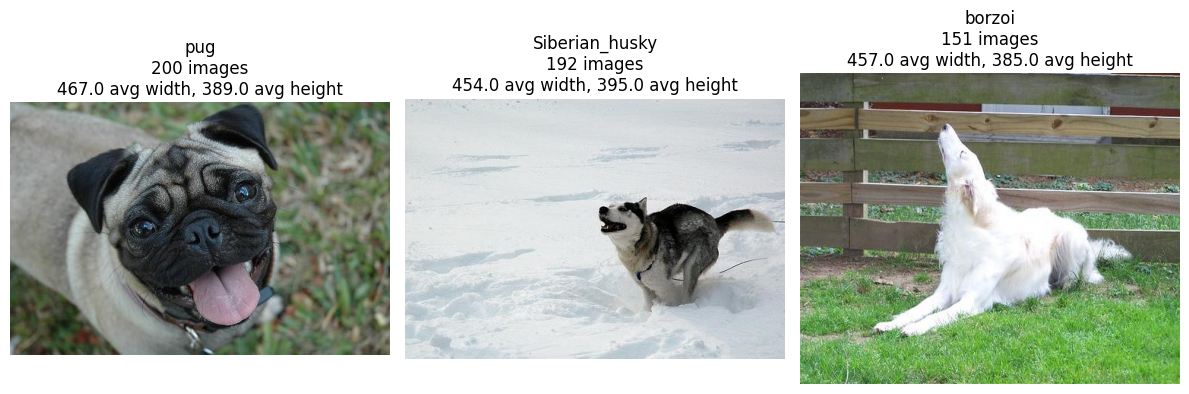

original shape (20580, 10) -> selected (543, 10)


In [4]:
m_n_img = img_df["class_label"].value_counts().values.mean()
m_w = img_df["width"].mean().round(0)
m_h = img_df["height"].mean().round(0)

print(f"{m_n_img} images per class, {m_w} avg width, {m_h} avg height")

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

for i, c in enumerate(CLASSES_3):
    _ = img_df.loc[img_df["class_label"] == c]

    # n images
    n_img = _["ID"].nunique()
    # mean width
    m_w = _["width"].mean().round(0)
    # mean height
    m_h = _["height"].mean().round(0)

    # pick image
    img = Image.open(_["img_uri"].to_list()[0])

    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"{c}\n{n_img} images\n{m_w} avg width, {m_h} avg height")

plt.tight_layout()
plt.show()
plt.close()

img_ds = img_df.loc[img_df["class_label"].isin(CLASSES_3)]
print(f"original shape {img_df.shape} -> selected {img_ds.shape}")

## Échantillonnage et encodage

In [5]:
y = img_ds["class_label"]
X = img_ds["img_uri"]

# label_encoder = LabelEncoder()
# y_enc = label_encoder.fit_transform(y)
# for further decoding
# label_encoder.inverse_transform(y_enc)

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# create samples directories
if not os.path.exists(TRAIN_DIR):
    os.makedirs(TRAIN_DIR)
if not os.path.exists(TEST_DIR):
    os.makedirs(TEST_DIR)
if not os.path.exists(CHKPT_DIR):
    os.makedirs(CHKPT_DIR)


def copy_images(X, dir) -> None:
    i = 0
    for src_uri in X:
        img_name = src_uri.split("/")[-1]
        img_class = src_uri.split("/")[-2].split("-")[-1]
        dest_uri = os.path.join(dir, img_class, img_name)
        # create folder if needed
        if not os.path.exists(os.path.join(dir, img_class)):
            os.makedirs(os.path.join(dir, img_class))
        # copy image
        if not os.path.exists(dest_uri):
            shutil.copy2(src_uri, dest_uri)
        # count processed images
        i += 1
    print(f"{i} images processed")


copy_images(X_train, TRAIN_DIR)
copy_images(X_test, TEST_DIR)

488 images processed
55 images processed


## Configuration commune

In [6]:
input_size = (224, 224)
batch_size = 48
n_epochs = 100
optimizer = AdamW(learning_rate=0.0002, weight_decay=0.05)
loss = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

## Jeux de données

In [7]:
print("Train / val datasets:")
train_ds, val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    validation_split=0.2,  # train / val split
    subset="both",  # returns both train and val datasets
    shuffle=True,  # shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

print("\nTest dataset:")
test_ds = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",  # class names upon folders structure
    label_mode="int",  # integer encoding
    shuffle=False,  # do not shuffles images
    seed=42,  # random seed
    image_size=input_size,  # automatic resizing
    batch_size=batch_size,  # tensor shape[0]
)

Train / val datasets:


Found 488 files belonging to 3 classes.
Using 391 files for training.
Using 97 files for validation.

Test dataset:
Found 55 files belonging to 3 classes.


In [8]:
print(train_ds, "\n", val_ds, "\n", test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))> 
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Transfer Learning

Le *transfer learning* permet :
- l'économie de ressources et de temps
- le réentraînement des seules couches supérieures
- d'**éviter le surentraînement** puisque lors d'un apprentissage de zéro, le **nombre de paramètres à apprendre étant largement supérieur au nombre d'images**

Le choix du modèle se fait selon :
- le jeu de données d'entrée
- la similarité avec notre problématique
- la stratégie adoptée

## Fine-tuning total

**Lorsque la nouvelle collection d'images est grande**, on peut se permettre d'entraîner tout le réseau sans courir le risque de sur-entraînement et comme les paramètres de toutes les couches (sauf de la dernière) sont initialement ceux du réseau pré-entraîné, la phase d'apprentissage sera faite plus rapidement que si l'initialisation avait été aléatoire.

On **remplace la dernière couche** (dense) du réseau pré-entraîné par un **classifieur adapté au nouveau problème** et **initialisé de manière aléatoire** → toutes les couches sont ensuite entraînées sur les nouvelles images.

> ➡️ cette stratégie n'est donc pas applicable ici car la collection d'images est petite (150 à 200 images par classe)

## Extraction des features

**Lorsque la nouvelle collection d'images est petite** entraîner un réseau complet mènerait à un sur-entraînement.  
**Si elle est en plus similaire aux images de pré-entraînement**, on peut **se servir des features du réseau pré-entraîné pour représenter les images du nouveau problème** car les nouvelles images peuvent alors être représentées par les mêmes features.

Pour cela, on **retire la dernière couche dense** et on **fixe tous les autres paramètres** → le réseau va calculer la représentation de chaque image à partir des features déjà apprises lors du pré-entraînement.  
On entraîne alors un **classifieur, initialisé aléatoirement**, sur ces représentations pour résoudre le nouveau problème.

> ➡️ cette stratégie pourrait être applicable ici à condition d'avoir un modèle pré-entraîné sur des images assez similaires

## Fine-tuning partiel

Cette stratégie est utilisée **lorsque la nouvelle collection d'images est petite mais très différente** des images du pré-entraînement :
- comme il y a peu d'images d'entraînement, la stratégie de fine-tuning total n'est pas envisageable à cause du risque d'overfitting
- les nouvelles images ont très peu de points communs avec les anciennes : utiliser les features du réseau pré-entraîné pour les représenter n'est pas une bonne idéé

Il s'agit **compromis** mélangeant les stratégies précédentes : on **remplace la dernière couche dense par le nouveau classifieur initialisé aléatoirement**, et on **fixe les paramètres de certaines couches** du réseau pré-entraîné.  
Ainsi, **en plus du classifieur**, on entraîne sur les nouvelles images les **couches non-fixées**, qui correspondent en général aux plus hautes couches du réseau.

> ➡️ cette stratégie pourrait être applicable, si par exemple on dispose d'un modèle performant mais n'ayant jamais vu d'images de chien

# VGG16

<img src="https://user.oc-static.com/upload/2018/03/14/15209908694697_vgg-16-3dc.png">

**Entraîné lui aussi sur ImageNet** (pour rappel, le Stanford Dogs Dataset est issue du jeu de données ImageNet), ce modèle **ne nécessite qu'une extraction de features**.

Il est conçu pour détecter 1000 classes : lors du changement de classifieur on devra donc utiliser une **couche dense à 3 sorties** à la place de 1000.

- [Documentation Keras ici](https://keras.io/api/applications/vgg/#vgg16-function)

# 🦄🦄 CHECKPOINT 🦄🦄

- ?

In [9]:
model_name = "vgg16_3c"

In [10]:
def eval_pretrained_model(
    model,
    train_ds,
    val_ds,
    test_ds,
    LOG_DIR,
    CHKPT_DIR,
    model_name="raw_model",
    input_size=(224, 224),
    batch_size=32,
    n_epochs=10,
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
) -> tuple:
    """Train, evaluate and log model from architecture and configuration

    Return model, history and plot confusion matrix
    """

    if not os.path.exists(CHKPT_DIR):
        os.makedirs(CHKPT_DIR)
    chkpt_name = model_name + ".weights.h5"
    chkpt_uri = os.path.join(CHKPT_DIR, chkpt_name)

    model_config = f"""
| Config | Value |
|:---:|:---:|
| **model name** | {model_name} |
| **input size** | {input_size} |
| **batch size** | {batch_size} |
| **n epochs** | {n_epochs} |
| **optimizer** | {optimizer} |
| **loss** | {loss} |
| **metrics** | {metrics} |
| **best weights URI** | {chkpt_uri} |
    """

    # set log folder
    log_dir = os.path.join(
        LOG_DIR, model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    # COMPLIE
    logging.info("⚙️ compiling")
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )

    # CALLBACKS
    logging.info("🛎️ declaring callbacks")

    class TimingCallback(Callback):
        def __init__(self):
            self.logs = []
            self.start_time = None

        def on_train_begin(self, logs={}):
            self.start_time = time.time()

        # log time by epoch
        def on_epoch_end(self, epoch, logs={}):
            self.logs.append(time.time() - self.start_time)

        # log total time
        def on_train_end(self, logs={}):
            self.tot_time_sec = time.time() - self.start_time
            self.total_time = f"Total train time: {self.tot_time_sec // 60 :.0f}'{self.tot_time_sec % 60 :.0f}s"

    timing_callback = TimingCallback()
    checkpoint = ModelCheckpoint(
        chkpt_uri,
        save_best_only=True,
        save_weights_only=True,
    )
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=4, restore_best_weights=True
    )

    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,  # do not save weights & biases (too much memory)
        write_graph=True,
        write_images=True,
        update_freq="epoch",
    )

    # FIT
    logging.info("💪 starting training")
    model_history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=n_epochs,
        callbacks=[timing_callback, checkpoint, early_stopping, tensorboard_callback],
    )

    # EVALUATE ON TEST DATASET
    logging.info("🧐 evaluating model")
    model.load_weights(chkpt_uri)
    test_loss, *test_metrics = model.evaluate(test_ds)
    predictions = model.predict(test_ds)

    # CONFUSION MATRIX
    logging.info("📈 plotting results")
    # get true labels from test dataset
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    # convert predictions to classes
    predicted_classes = np.argmax(predictions, axis=1)
    # compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_classes)
    # precision & F1 score
    report = classification_report(
        true_labels,
        predicted_classes,
        target_names=test_ds.class_names,
    )
    report_dict = classification_report(
        true_labels,
        predicted_classes,
        target_names=test_ds.class_names,
        output_dict=True,
    )
    print(report)

    # plot it
    conf_mtx_plot = plt.figure(figsize=(6, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=test_ds.class_names,
        yticklabels=test_ds.class_names,
    )
    plt.suptitle(f"{model_name} model", color="blue", weight="bold")
    plt.title(
        f"acc. {report_dict['accuracy'] :.02f} - loss {test_loss :.02f} - {timing_callback.total_time}",
        fontsize=10,
    )
    plt.xlabel("Predictions", color="red", weight="bold")
    plt.ylabel("True labels", color="green", weight="bold")
    plt.show()

    # convert image for Tensorboard
    conf_mtx_plot.canvas.draw()
    image_array = np.array(conf_mtx_plot.canvas.renderer.buffer_rgba())
    conf_mtx_plot_tf = tf.convert_to_tensor(image_array)
    conf_mtx_plot_tf = tf.expand_dims(conf_mtx_plot_tf, 0)

    plt.close()

    # LOG IN TENSORBOARD
    logging.info("📓 logging results")
    file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
    with file_writer.as_default():
        tf.summary.text("configuration", model_config, step=0)
        tf.summary.text("total_training_time", timing_callback.total_time, step=0)
        for i, time_per_epoch in enumerate(timing_callback.logs):
            tf.summary.scalar("time_per_epoch", time_per_epoch, step=i + 1)
        tf.summary.image("confusion_matrix", conf_mtx_plot_tf, step=0)

    return model, model_history

In [11]:
# load pre-trained VGG-16 without top layers
model = VGG16(
	  weights="imagenet",       # pre-trained weights
	  include_top=False,        # no dense layer
	  input_shape=(input_size[0], input_size[1], 3) # input shape
)
# create explicit input layer
inputs = tf.keras.Input(shape=(input_size[0], input_size[1], 3))
# add data augmentation
augmented = ConditionalAugmentation(rate=0.4)(inputs)
x = model(augmented)

# flatten output
x = Flatten()(x)
# for feature extraction only
for layer in model.layers:
   layer.trainable = False
# new FC layer for 3 classes classification
predictions = Dense(3, activation='softmax')(x)
# define new model
vgg16_3c = Model(inputs=inputs, outputs=predictions)
# display model summary
vgg16_3c.summary()

/home/jl/projets/oc_p6/.venv/lib/python3.11/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'conditional_augmentation', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conditional_augmentation        │ (None, 224, 224, 3)    │             0 │
│ (ConditionalAugmentation)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        75,267 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,789,955 (56.42 MB)

 Trainable params: 75,267 (294.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
%%time

model_trained, history = eval_pretrained_model(
    model=vgg16_3c,
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds,
    LOG_DIR=LOG_DIR,
    CHKPT_DIR=CHKPT_DIR,
    model_name=model_name,
    input_size=input_size,
    batch_size=batch_size,
    n_epochs=n_epochs,
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

INFO:root:⚙️ compiling
INFO:root:🛎️ declaring callbacks
INFO:root:💪 starting training


Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 131s 15s/step - accuracy: 0.4213 - loss: 14.3094 - val_accuracy: 0.7010 - val_loss: 4.8477
Epoch 2/100


🚧🚧

``` python
# compile
vgg16_3c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
# train on new data
vgg16_3c_info = vgg16_3c.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)
```